# Salary Predictions Based on Job Descriptions

**Author:**    Kevin O'Hara <br>
**Email:** kohara91@gmail.com <br>
**LinkedIn:**  https://www.linkedin.com/in/kevinodata/

Searching for jobs induces a sense of uncertainty. Will we find the right one? Will we enjoy our new responsibilities? And, of course, how will we be compensated? 

There are plenty of other things to consider, but this last aspect is something we can shed light on. There are online resources available to obtain this information, but we can also get an idea with machine learning. 

Using an imported list of job postings and their associated salaries, I will develop a model to predict a salary dependent on employee features. The model effectiveness will be evaulated by determining the mean squared error. This tool can prove useful for both businesses and individuals searching for new careers. An effective model can be used by HR to determine an adequate salary to offer to potential hires, and may also be used by individuals to request a reasonable salary. I will aim for a MSE less than 360 before testing and deploying this model. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

### Functions Used

In [2]:
# For cleaning our data to remove $0 salaries
def clean_this(df):
    clean_this = df[df.salary>0]
    cleaned_df = clean_this.reset_index(drop=True)
    return cleaned_df
    
# For displaying distplots
def distribution_plot(real, predict, realLabel, predictLabel, title):
    plt.figure(figsize=(12,6))
    sns.distplot(real, hist=False, color='g', label = realLabel)
    sns.distplot(predict, hist=False, color='b', label = predictLabel)
    plt.xlabel('Salary')
    plt.ylabel('Probability Density Function')
    plt.title(title)
    plt.legend()

### Loading our datasets

In [3]:
train_salaries = pd.read_csv('data/train_salaries.csv')
train_job_postings = pd.read_csv('data/train_features.csv')
test_job_postings = pd.read_csv('data/test_features.csv')

### First Examination

In [20]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [6]:
train_salaries.shape

(1000000, 2)

In [21]:
train_salaries.isnull().any()

jobId     False
salary    False
dtype: bool

In [22]:
train_job_postings.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
train_job_postings.shape

(1000000, 8)

In [10]:
train_job_postings.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [11]:
train_job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


From here, we can verify that the data is loaded and see that there are 1,000,000 rows to work with. With .head and .info, we can see that most of the values are categorical, and that there are no missing values (no nulls). We will need to encode a fair amount of our features to get them ready to model. Fortunately, since there are no missing values, we will not need to impute any additional values.  

We can also see that the salaries and additional features are linked by a jobId. This allows us to stitch them together with the id to get them all on one dataframe.

The last dataset will act as our test data, since it contains all of the same features without any salaries. We will use this to determine our best model.

### Cleaning/Pre-processing

The 'job_postings' dataframe (df) contains all of our features of interest. Of those features, 'jobType' and 'degree' are ordinal and could be encoded as such. We can assume that job roles higher in a company will have a higher salary, so CFO, CEO, CTO, and Vice_President would be ordered higher than Junior level positions. We can also assume that higher degrees will likely increase the potential salary, so could also encode them in an ordinal fashion.

For now, we will stitch the dfs together using jobId and make sure that our new df has values we would expect.

In [19]:
train_job_postings['jobType'].unique()

array(['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR',
       'CTO', 'SENIOR'], dtype=object)

In [20]:
train_job_postings['degree'].unique()

array(['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE'],
      dtype=object)

In [21]:
train_job_postings['industry'].unique()

array(['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE'],
      dtype=object)

In [4]:
train_data = pd.merge(train_salaries, train_job_postings, on='jobId')

# Verify the merge occurred properly
train_data.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


Now that we've merged the dataframes, we will examine the whole table and make sure it's clean. The only tables that could be suspect are the numerical values - salary, yearsExperience, and milesFromMetropolis. The categorical features all have unique identifiers that make sense. We can check on the range of numerical values to see if it's normal.

In [8]:
train_data.describe()

,salary,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000,1000000.000000
mean,116.061818,11.992386,49.529260
std,38.717936,7.212391,28.877733
min,0.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


The range for all of the values seem reasonable except for the salary. There appear to be some \\$0 salaries. Since the goal of this model is to develop a way to predict salaries, we are better off removing the \\$0 salary rows. 

In [5]:
# Determine how many zero salaries we have
no_salary = train_data['salary']<=0
bad_train_data = train_data[no_salary]
bad_train_data

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


There appear to be 5 with no salary. We will use the clean_this function to clear these values from the train_data and reset the index.

In [6]:
model_train_data = clean_this(train_data)
model_train_data.tail()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
999990,JOB1362685407682,88,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94
999991,JOB1362685407683,160,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35
999992,JOB1362685407684,64,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81
999993,JOB1362685407685,149,COMP3,CFO,MASTERS,NONE,HEALTH,6,5
999994,JOB1362685407686,88,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11


### Exploratory Data Analysis

In [11]:
model_train_data.describe()

,salary,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000
mean,116.062398,11.992407,49.529381
std,38.717163,7.212390,28.877721
min,17.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


These values appear to be reasonable. Our training salaries range from 17 - 301 thousand with some clustering in the IQR, while the yearsExperience and milesFromMetropolis are pretty evenly spread in chunks of 6 and 25, respectively. The mean and std_dev seem appropirate for this as well.

In [12]:
model_train_data.nunique()

jobId                  999995
salary                    279
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
dtype: int64

There appears to be a unique jobId for each row. We will remove this feature as it will only generate noise in our model, if anything at all.

In [7]:
model_train_data.drop('jobId', axis=1, inplace=True)
model_train_data.head()

,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


We should now check to see if our target variable is normally distributed by examining the skew and kurtosis.

In [8]:
print('Skew:', model_train_data['salary'].skew())
print('Kurtosis:', model_train_data['salary'].kurt())

if -0.5 <= model_train_data['salary'].skew() <= 0.5 and -1 <= model_train_data['salary'].kurt() <= 1:
    print('The salary is normally distributed')
else:
    print('The salary is not normally distributed')

Skew: 0.34652727907668734
Kurtosis: -0.025750772283374967
The salary is normally distributed


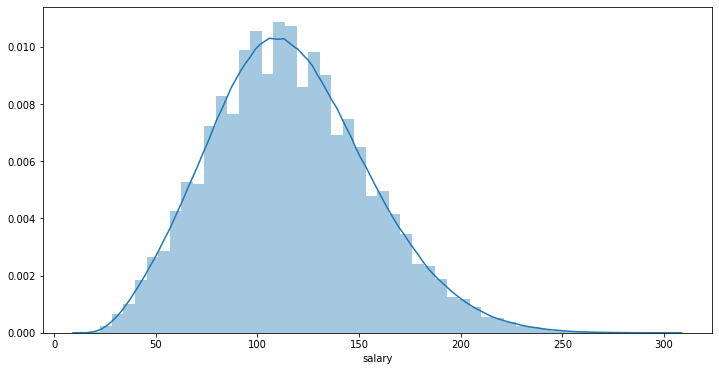

In [10]:
plt.figure(figsize=(12,6))
sns.distplot(model_train_data['salary'])

Our target variable appears to be roughly normally distributed. Now let's examine the relationship of this variable between the potential features: <br>
- companyId <br>
- jobType <br>
- degree <br>
- major <br>
- industry <br>
- yearsExperience <br>
- milesFromMetropolis

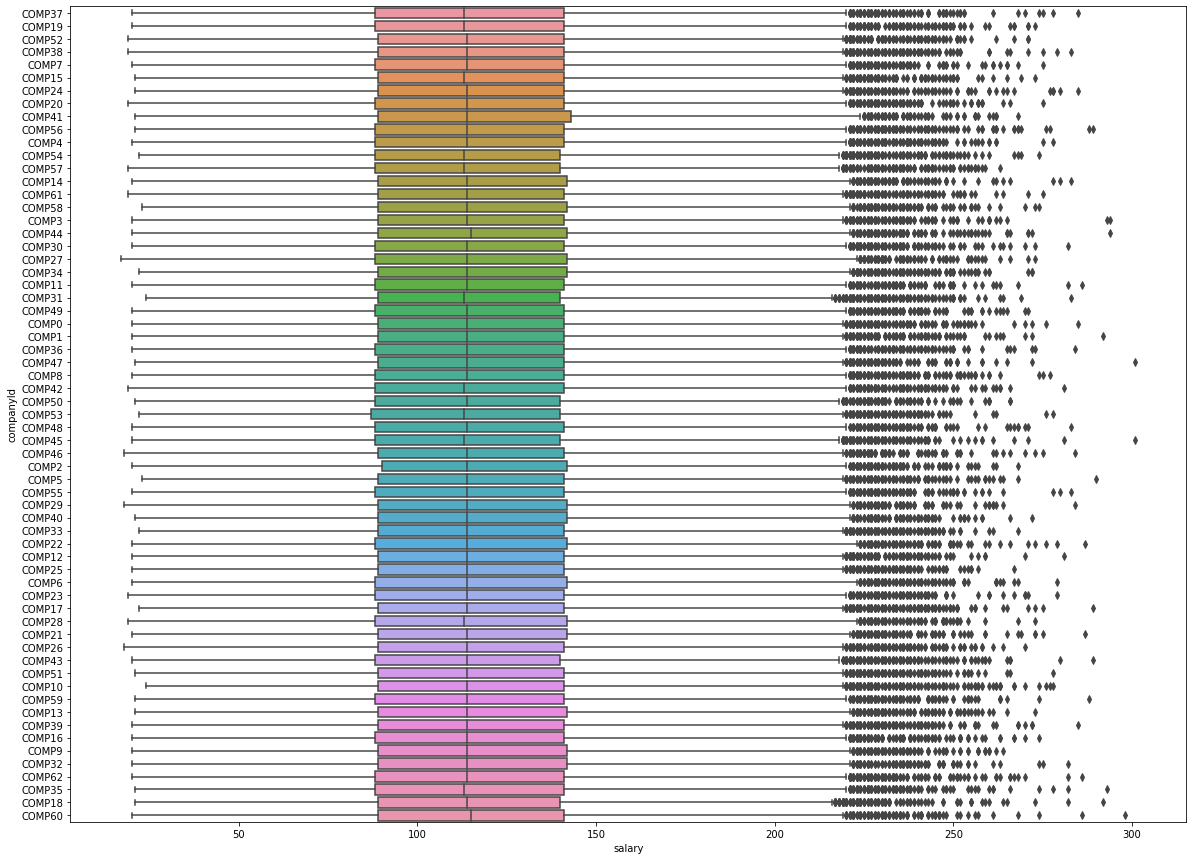

In [46]:
# companyId first. With 63 unique values, I'm skeptical to it's use here, so let's use a boxplot to determine it's relationship
plt.figure(figsize=(20,15))
sns.boxplot(data=model_train_data, x='salary', y='companyId')

The salaries appear to be pretty evenly distributed by company. This tells us that the feature is not a good predictor, and is best removed from the df.

In [9]:
model_train_data.drop('companyId', axis=1, inplace=True)
model_train_data.head()

,salary,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,130,CFO,MASTERS,MATH,HEALTH,10,83
1,101,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,137,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,142,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,163,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


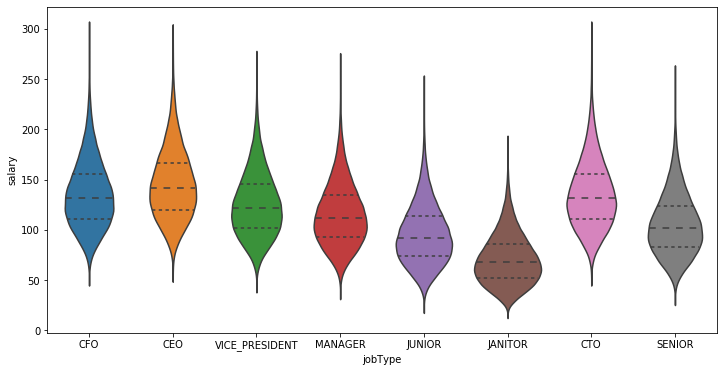

In [12]:
# jobType next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='jobType', y='salary', inner='quartile')

C-level positions appear to have the higher salary, and junior/janitor positions at the lowest. This appears to be a fairly important feature in our salary prediction. While this is expected, the above plot shows it's importance clearly.

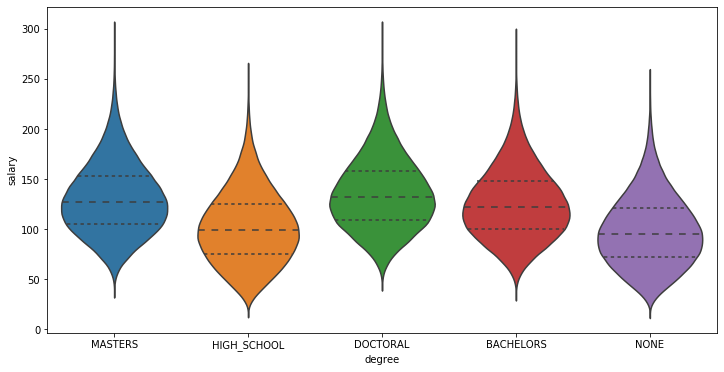

In [50]:
# degree next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='degree', y='salary', inner='quartile')

Higher education seems to equate to a higher salary, which lines up with our expectations. It's interesting to note that the median salary seems relatively stable with all higher-education degrees. There is a clear jump from none/high school to bachelors, and the masters/doctoral degrees are about on the same level.

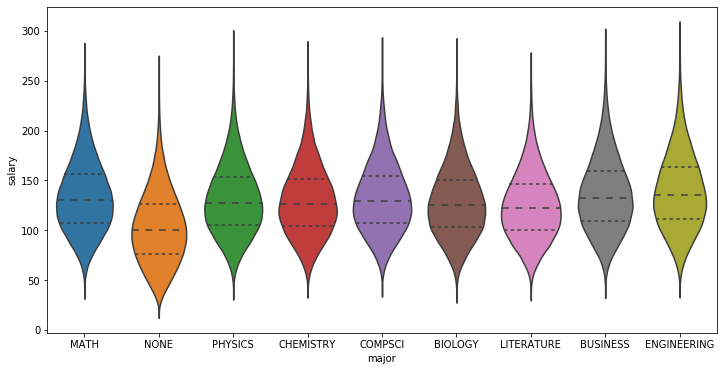

In [51]:
# major next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='major', y='salary', inner='quartile')

There appears to only be a noticable drop in salary when there is no degree. This is expected, but it is interesting to see that the median salary remains fairly consistent across all other majors.

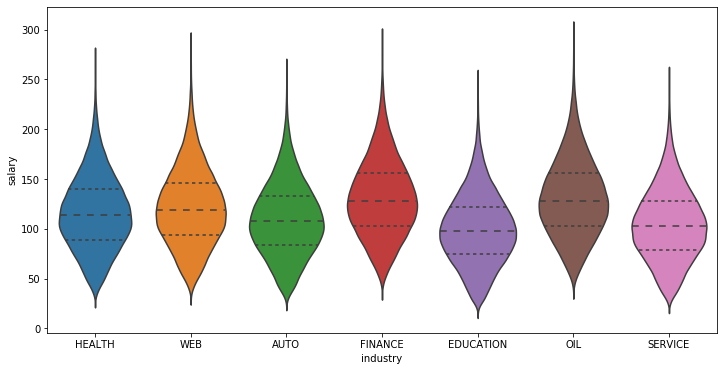

In [52]:
# industry next.
plt.figure(figsize=(12,6))
sns.violinplot(data=model_train_data, x='industry', y='salary', inner='quartile')

Finance and oil seem to have the highest salaries, which lines up with expectations. Auto, education, and service seem to have the lowest on average. 

(0, 150)

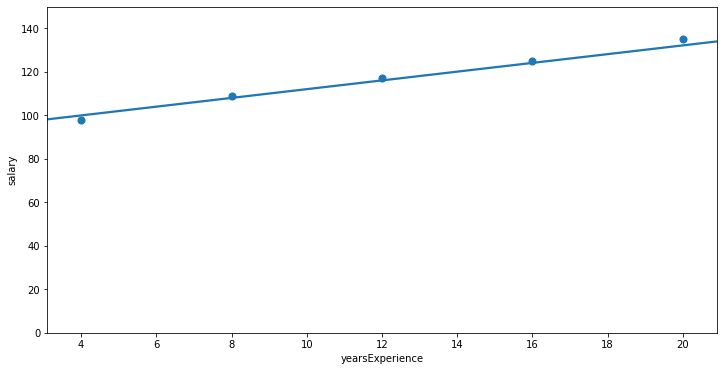

In [18]:
# yearsExperience next.
plt.figure(figsize=(12,6))
sns.regplot(data=model_train_data, x='yearsExperience', y='salary', x_bins=5)
plt.ylim(0,150)

There appears to be a slightly positive relationship between yearsExperience and salary

(0, 150)

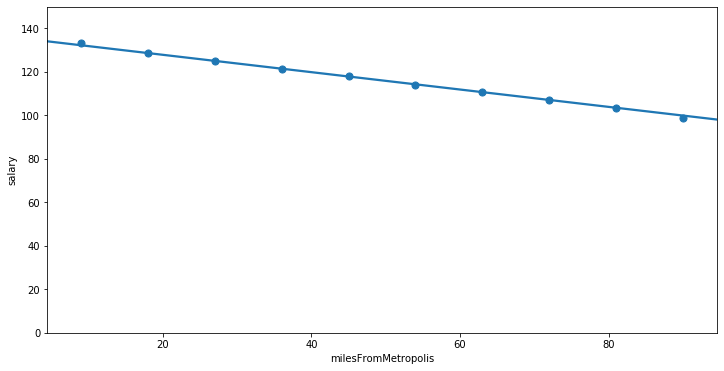

In [19]:
# milesFromMetropolis last.
plt.figure(figsize=(12,6))
sns.regplot(data=model_train_data, x='milesFromMetropolis', y='salary', x_bins=10)
plt.ylim(0,150)

This last feature gives us a slight negative relationship between milesFromMetropolis and salary, which is about what we'd expect. Since cost of living increases as our proximity to a city increases, we would expect our salary to also increase.


### Summary

Our target variable - salary - appears to be normally distributed with real values. <br> <br>
Our remaining categorical features seem to impact the salary in important ways. We ultimately removed two features: jobId and companyId, as they seemed to have no impact on the actual salary. The jobId seemed to be a row identifier, and the 63 unique companyId's all had very similar salary ranges. The remaining features all seem to be useful predictors of salary. 

### First Simple Model

To prepare our first model, we will first need to encode our categorical features. We will do this using Pandas. Once it's encoded, we will then need to split our X and y dataframes. X will be all of our features, and y will just contain the salary.

In [10]:
model_train_data = pd.get_dummies(model_train_data)
model_train_data.head()

,salary,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,130,10,83,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,101,3,73,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,137,10,38,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,142,8,17,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,163,8,16,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [11]:
X = model_train_data[model_train_data.loc[:, model_train_data.columns != 'salary'].columns]
y = model_train_data['salary']

X.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,8,17,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [12]:
# Our features all seem to be there. All that's left is to split our data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Our first simple model will be a Linear Regression. This will be the most straightforward to create and should predict reasonably well for our continuous target variable.

In [13]:
# First we need to create the object and fit it to our training data.
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Next we will write out the predictions
y_predict = linear_model.predict(X_train)

Our baseline for the model effectiveness is mean squared error (MSE). Now that we have some predictions, let's see how well the model works. We will also calculate the score or R^2 of the model, which measures how close the data is fitted to the regression line. The R^2 equates to the accuracy of the model.

In [15]:
print('MSE:', mean_squared_error(y_train, y_predict))
print('R^2:', linear_model.score(X_train, y_train))

MSE: 384.6575428230048
R^2: 0.7437143107868367


In [16]:
# Let's see how accurate the model is using a 5fold CV
five_fold = cross_val_score(linear_model, X_train, y_train, cv=5)
print('5fold accuracy:', five_fold.mean())

5fold accuracy: 0.7436939433546574


We can also use a distribution plot to visualize the accuracy of our predictions.

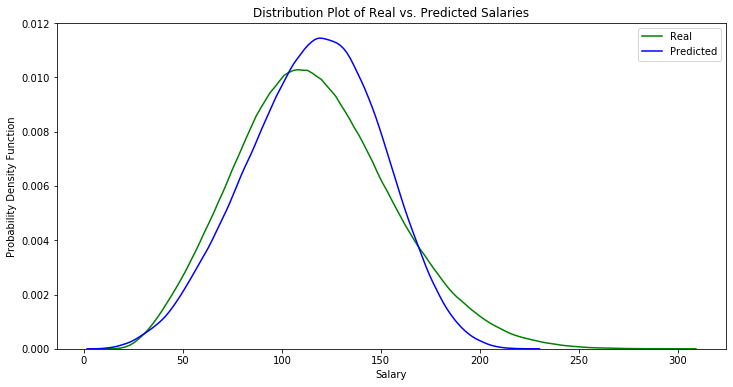

In [23]:
# Using a function created earlier
distribution_plot(y_train, y_predict, 'Real', 'Predicted', 'Distribution Plot of Real vs. Predicted Salaries')

The predictions seem fairly accurate. The mean is noticeably shifted slightly up. These plots seem to confirm the accuracy of our R^2 calculations earlier.

I will attempt to improve on the MSE with some more advanced models. The three that I'd like to try are:
<br>
 - LassoLars Linear Regression using Backwards Elimination
 - Support Vector Regression
 - Gradient Boosting Classifier

The LassoLars method may prove more accurate than a simple linear regression as we will be able to trim features that are less important.
<br><br>
Support Vector Regression with a linear kernel should work well with the large number of samples we have. From our EDA, the data seems to be organized well enough to model effectively with SVMs. 
<br><br>
Lastly, we will try a Gradient Boosting Classifier. This model tends to work very well for a wide variety of data sets, and this may be no different.


### LassoLars Linear Regression

In [18]:
# First we will set our model
lassolars_model = LassoLars()

# Then we will make us of GridSearchCV to tune our hyperparameter
llars_param_grid = {'alpha' : [0.1, 0.25, 0.5, 0.75, 1.0]}
llars = GridSearchCV(lassolars_model, llars_param_grid, cv=5)

# Next we will fit the optimized regression with our training data
llars.fit(X_train, y_train)

# Let's inspect the best alpha
print('The best alpha value is ',llars.best_params_)

The best alpha value is  {'alpha': 0.1}


In [20]:
# We will now make our predictions and determine the accuracy of this model
llars_predict = llars.predict(X_train)

In [21]:
print('MSE:', mean_squared_error(y_train, llars_predict))
print('R^2:', llars.score(X_train, y_train))

MSE: 1500.8935692194248
R^2: 0.0


### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data